# Construire et entraîner un perceptron multi-couches - étape par étape

Dans ce TP, vous allez mettre en œuvre l'entraînement d'un réseau de neurones (perceptron multi-couches) à l'aide de la librairie **numpy**. Pour cela nous allons procéder par étapes successives. Dans un premier temps nous allons traiter le cas d'un perceptron mono-couche, en commençant par la passe *forward* de prédiction d'une sortie à partir d'une entrée et des paramètres du perceptron, puis en implémentant la passe *backward* de calcul des gradients de la fonction objectif par rapport aux paramètres. A partir de là, nous pourrons tester l'entraînement à l'aide de la descente de gradient stochastique.

Une fois ces étapes achevées, nous pourrons nous atteler à la construction d'un perceptron multi-couches, qui consistera pour l'essentiel en la composition de perceptrons mono-couche.

Dans ce qui suit, nous adoptons les conventions de notation suivantes :

- $(x, y)$ désignent un couple donnée/label de la base d'apprentissage ; $\hat{y}$ désigne quant à lui la prédiction du modèle sur la donnée $x$.

- L'indice $i$ indique la $i^{\text{ème}}$ dimension d'un vecteur ⇒ $a_i$

- L'exposant $(k)$ désigne un objet associé au $k^{\text{ème}}$ exemple ⇒ $a_i^{(k)}$

- L'exposant $[l]$ désigne un objet associé à la $l^{\text{ème}}$ couche ⇒ $a_i^{(k)[l]}$
   
Exemple:  
- $a_5^{(2)[3]}$ indique donc la $5^{\text{ème}}$ dimension du vecteur d'activation du $2^{\text{ème}}$ exemple d'entraînement (2), de la $3^{\text{ème}}$ couche [3].


Commençons par importer tous les modules nécessaires :

In [1]:
import numpy as np

import math
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets

import numpy as np

def print_decision_boundaries(model, X, y):
    """
    Affiche les frontières de décision d'un modèle.

    Arguments :
    model -- le modèle de classification entraîné.
    X -- les données d'entrée, de dimensions (N, 2).
    y -- les étiquettes de classe, de dimensions (N,).
    """
    # Crée une grille de points pour couvrir l'espace des données
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    # Prédit les classes pour chaque point de la grille
    Z = model.forward(np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)

    # Utilise les résultats pour colorer les régions de décision
    plt.contourf(xx, yy, Z, alpha=0.4)

    # Affiche également les données
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.show()


In [2]:
import numpy as np

def relu(Z):
    """
    Implémentation de la fonction d'activation ReLU
    """
    return np.maximum(0, Z)

def sigmoid(Z):
    """
    Implémentation de la fonction d'activation Sigmoid
    """
    return 1 / (1 + np.exp(-Z))

def dense_layer_forward(x, Wxy, by, activation):
    """
    Réalise une unique étape forward de la couche dense telle que décrite dans la figure précédente

    Arguments:
    x -- l'entrée, tableau numpy de dimension (n_x, m).
    Wxy -- Matrice de poids multipliant l'entrée, tableau numpy de shape (n_y, n_x)
    by -- Biais additif ajouté à la sortie, tableau numpy de dimension (n_y, 1)
    activation -- Chaîne de caractère désignant la fonction d'activation choisie : 'linear', 'sigmoid' ou 'relu'

    Retourne :
    y_pred -- prédiction, tableau numpy de dimension (n_y, m)
    cache -- tuple des valeurs utiles pour la passe backward (rétropropagation du gradient), contient (x, z)
    """

    # calcul de z
    z = np.matmul(Wxy, x) + by

    # calcul de la sortie en appliquant la fonction d'activation
    if activation == 'relu':
        y_pred = relu(z)
    elif activation == 'sigmoid':
        y_pred = sigmoid(z)
    elif activation == 'linear':
        y_pred = z
    else:
        print("Erreur : la fonction d'activation n'est pas implémentée.")
        y_pred = None

    # sauvegarde du cache pour la passe backward
    cache = (x, z)

    return y_pred, cache


### Perceptron mono-couche - passe *backward*

Dans les librairies d'apprentissage profond actuelles, il suffit d'implémenter la passe *forward*, et la passe *backward* est réalisée automatiquement, avec le calcul des gradients (différentiation automatique) et la mise à jour des paramètres. Il est cependant intéressant de comprendre comment fonctionne la passe *backward*, en l'implémentant sur un exemple simple.

<img src="https://drive.google.com/uc?id=1MC8Nxu6BQnpB7cGLwunIbgx9s1FaGw81" height=350>

Il faut calculer les dérivées de la fonction objectif par rapport aux différents paramètres, pour ensuite mettre à jour ces derniers pendant la descente de gradient. Les équations de calcul des gradients sont données ci-dessous (c'est un bon exercice que de les calculer à la main).

\begin{align}
\displaystyle dx &= \frac{\partial J}{\partial x} &= { W_{xy}}^T \: \left( d\hat{y} * \frac{\partial \hat{y}}{\partial z} \right) \tag{1}  \\[8pt]
\displaystyle  {dW_{xy}} &= \frac{\partial J}{\partial W_{xy}} &= \left( d\hat{y} * \frac{\partial \hat{y}}{\partial z} \right) \: x^{T}\tag{2} \\[8pt]
\displaystyle db_{y} &= \frac{\partial J}{\partial b_y} &= \sum_{i=1}^m \left( d\hat{y} * \frac{\partial \hat{y}}{\partial z} \right) \tag{3} \\[8pt]
\end{align}


Ici, $*$ indique une multiplication élément par élément tandis que l'absence de symbole indique une multiplication matricielle. Par ailleurs $d\hat{y}$ désigne $\frac{\partial J}{\partial \hat{y}}$, $dW_{xy}$ désigne $\frac{\partial J}{\partial W_{xy}}$, $db_y$ désigne $\frac{\partial J}{\partial b_y}$ et $dx$ désigne $\frac{\partial J}{\partial x}$ (ces noms ont été choisis pour être utilisables dans le code).

Il vous reste à déterminer, par vous même, le terme $\frac{\partial \hat{y}}{\partial z}$, qui constitue en fait la dérivée de la fonction d'activation évaluée en $z$. Par exemple, pour la fonction d'activation linéaire (l'identité), la dérivée est égale à 1 pour tout $z$. A vous de déterminer, et d'implémenter, la dérivée des fonctions *sigmoid* et *relu*. **Attention aux dimensions : $\frac{\partial \hat{y}}{\partial z}$ est de même dimension que $z$ et $\hat{y}$ !**



In [3]:
def relu_backward(dA, Z):
    """
    La dérivée de ReLU par rapport à Z.
    """
    dZ = np.array(dA, copy=True)  # Convertir dA en un objet numpy array si ce n'est pas déjà le cas
    dZ[Z <= 0] = 0
    return dZ

def sigmoid_backward(dA, Z):
    """
    La dérivée de sigmoid par rapport à Z.
    """
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    return dZ

def dense_layer_backward(dy_hat, Wxy, by, activation, cache):
    """
    Implémente la passe backward de la couche dense.

    Arguments :
    dy_hat -- Gradient de la fonction objectif par rapport à la sortie ŷ, de dimension (n_y, m)
    Wxy -- Matrice de poids multipliant l'entrée, tableau numpy de shape (n_y, n_x)
    by -- Biais additif ajouté à la sortie, tableau numpy de dimension (n_y, 1)
    cache -- dictionnaire python contenant des variables utiles (issu de dense_layer_forward())

    Retourne :
    gradients -- dictionnaire python contenant les gradients suivants :
                        dx -- Gradient de la fonction objectif par rapport aux entrées, de dimension (n_x, m)
                        dby -- Gradient de la fonction objectif par rapport aux biais, de dimension (n_y, 1)
                        dWxy -- Gradient de la fonction objectif par rapport aux poids synaptiques Wxy, de dimension (n_y, n_x)
    """
    # Récupérer les informations du cache
    (x, z) = cache

    # calcul de la dérivée de la fonction d'activation par rapport à z
    if activation == 'relu':
        dyhat_dz = relu_backward(dy_hat, z)
    elif activation == 'sigmoid':
        dyhat_dz = sigmoid_backward(dy_hat, z)
    elif activation == 'linear':
        dyhat_dz = dy_hat  # La dérivée d'une fonction linéaire est 1
    else:
        print("Erreur : la fonction d'activation n'est pas implémentée.")
        dyhat_dz = None

    # calculer le gradient de la perte par rapport à x
    dx = np.dot(Wxy.T, dyhat_dz)

    # calculer le gradient de la perte par rapport à Wxy
    dWxy = np.dot(dyhat_dz, x.T)

    # calculer le gradient de la perte par rapport à by
    dby = np.sum(dyhat_dz, axis=1, keepdims=True)

    # Stocker les gradients dans un dictionnaire
    gradients = {"dx": dx, "dby": dby, "dWxy": dWxy}

    return gradients



On peut maintenant créer une classe *DenseLayer*, qui comprend en attribut toutes les informations nécessaires à la description d'une couche dense, c'est-à-dire :


*   Le nombre de neurones en entrée de la couche dense (input_size)
*   Le nombre de neurones en sortie de la couche dense (output_size)
*   La fonction d'activation choisie sur cette couche (activation)
*   Les poids synaptiques de la couche dense, stockés dans une matrice de taille (output_size, input_size) (Wxy)
*   Les biais de la couche dense, stockés dans un vecteur de taille (output_size, 1) (by)

On ajoute également un attribut cache qui permettra de stocker les entrées de la couche dense (x) ainsi que les calculs intermédiaires (z) réalisés lors de la passe *forward*, afin d'être réutilisés pour la basse *backward*.

A vous de compléter les 4 jalons suivants :

*   **L'initialisation des paramètres** Wxy et by : Wxy doit être positionnée suivant l'initialisation de Glorot, c'est-à-dire que ses valeurs sont échantillonnées selon une loi uniforme :
$$ W_{xy}^{\{0\}} \sim \mathcal{U}_{\left[-\sqrt{\frac{6}{n_x + n_y}}, \sqrt{\frac{6}{n_x + n_y}}\right]}$$

et by est initialisée par un vecteur de zéros de taille (output_size, 1).
*   **La fonction *forward***, qui consiste simplement en un appel de la fonction *dense_layer_forward* implémentée précédemment.
*   **La fonction *backward***, qui consiste simplement en un appel de la fonction *dense_layer_backward* implémentée précédemment.
*   Et enfin **la fonction *update_parameters*** qui applique la mise à jour de la descente de gradient en fonction d'un taux d'apprentissage (*learning_rate*) et des gradients calculés dans la passe *forward*.


In [4]:
import numpy as np

class DenseLayer:
    def __init__(self, input_size, output_size, activation):
        """
        Initialise une couche dense avec les paramètres spécifiés.
        
        Arguments:
        input_size -- nombre de neurones d'entrée
        output_size -- nombre de neurones de sortie
        activation -- la fonction d'activation à utiliser ('relu', 'sigmoid', 'linear')
        """
        self.input_size = input_size
        self.output_size = output_size
        self.activation = activation
        self.cache = None  # Pour stocker x et z lors de la passe forward

        # Initialisation des poids selon Glorot/Xavier
        limit = np.sqrt(6 / (input_size + output_size))
        self.Wxy = np.random.uniform(-limit, limit, (output_size, input_size))
        
        # Initialisation des biais à zéro
        self.by = np.zeros((output_size, 1))

    def forward(self, x_batch):
        """
        Effectue la passe forward à travers la couche dense.
        
        Arguments:
        x_batch -- entrées de la couche, de dimensions (input_size, m)
        
        Retourne:
        y -- sortie de la couche, après application de la fonction d'activation
        """
        y, cache = dense_layer_forward(x_batch, self.Wxy, self.by, self.activation)
        self.cache = cache
        return y

    def backward(self, dy_hat):
        """
        Effectue la passe backward, calculant les gradients nécessaires.
        
        Arguments:
        dy_hat -- gradient de la perte par rapport à la sortie de la couche
        
        Retourne:
        gradients -- un dictionnaire contenant les gradients par rapport à x, Wxy, et by
        """
        gradients = dense_layer_backward(dy_hat, self.Wxy, self.by, self.activation, self.cache)
        return gradients

    def update_parameters(self, gradients, learning_rate):
        """
        Met à jour les paramètres de la couche selon la descente de gradient.
        
        Arguments:
        gradients -- dictionnaire de gradients par rapport à Wxy et by
        learning_rate -- taux d'apprentissage pour la mise à jour des paramètres
        """
        # Mise à jour des poids et des biais selon la descente de gradient
        self.Wxy -= learning_rate * gradients['dWxy']
        self.by -= learning_rate * gradients['dby']


Pour entraîner notre modèle, nous devons mettre en place un optimiseur. Nous implémenterons la descente de gradient stochastique avec mini-batch. Il nous faut cependant au préalable implanter la fonction de coût que nous utiliserons pour évaluer la qualité de nos prédictions.

Pour le moment, nous allons nous contenter d'une erreur quadratique moyenne, qui associée à une fonction d'activation linéaire (l'identité) permet de résoudre les problèmes de régression.

La fonction de coût prend en entrée deux paramètres : la vérité-terrain *y_true* et la prédiction du modèle *y_pred* ($\hat{y}$). Ces deux matrices sont de dimension $n_y \times m$ (où $m$ désigne le nombre d'éléments du *batch*, et $n_y$ le nombre de neurones de la couche de sortie). La fonction retourne deux grandeurs : $J_{mb}$ qui correspond à l'erreur quadratique moyenne des prédictions par rapport aux vérités-terrains, et $d\hat{y}$ au gradient de l'erreur quadratique moyenne par rapport aux prédictions. Autrement dit :
$$ d\hat{y}  = \frac{\partial J_{mb}}{\partial \hat{y}}$$

où $\hat{y}$ correspond à *y_pred*, et $J_{mb}$ à la fonction objectif calculée sur un mini-batch $mb$ de données.

Dans le cas de l'erreur quadratique moyenne, on a :    

$$ J_{mb} = \frac{1}{m  n_y} \sum_{i=1}^{n_y} \sum_{j=1}^{m} (y_{ij} - \hat{y}_{ij})^2 $$

et

$$ \frac{\partial J_{mb}}{\partial \hat{y}} = \frac{-2}{m  n_y} (y - \hat{y})$$



In [5]:

def binary_cross_entropy(y_true, y_pred):
    """
    Calcule l'entropie croisée binaire et son gradient par rapport à y_pred.
    
    Arguments :
    y_true -- labels véritables, de dimension (n_y, m)
    y_pred -- prédictions du modèle, de dimension (n_y, m)
    
    Retourne :
    loss -- l'entropie croisée binaire, scalaire
    dy_hat -- gradient de l'entropie croisée par rapport à y_pred, de dimension (n_y, m)
    """
    epsilon = 1e-15  # pour éviter log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)  # Clip les prédictions pour éviter log(0)
    
    m = y_true.shape[1]  # Nombre d'exemples
    
    # Calcul de l'entropie croisée binaire
    loss = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / m
    
    # Calcul du gradient de l'entropie croisée par rapport à y_pred
    dy_hat = -(y_true / y_pred - (1 - y_true) / (1 - y_pred)) / m
    
    return loss, dy_hat

def mean_square_error(y_true, y_pred):
    
    """
    Erreur quadratique moyenne entre prédiction et vérité-terrain

    Arguments :
    y_true -- labels à prédire (vérité-terrain), de dimension (n_y, m)
    y_pred -- prédictions du modèle, de dimension (n_y, m)
    Retourne :
    J_mb -- l'erreur quadratique moyenne entre y_true et y_pred, scalaire
    dy_hat -- dérivée partielle de la fonction objectif par rapport à y_pred, de dimension (n_y, m)
    """    
    m, n_y = y_pred.shape  # m est le nombre d'exemples, n_y le nombre de sorties
    
    # Calcul de l'erreur quadratique moyenne
    J_mb = np.sum((y_true - y_pred) ** 2) / (m * n_y)
    
    # Calcul du gradient de l'erreur quadratique moyenne par rapport à y_pred
    dy_hat = (-2 / (m * n_y)) * (y_true - y_pred)
    
    return J_mb, dy_hat


### Descente de gradient stochastique

La descente de gradient stochastique prend en entrée les paramètres suivants :  
*    *x_train* et *y_train* respectivement les données et labels de l'ensemble d'apprentissage (que l'on suppose de taille $N$).
*    *model* une instance du modèle que l'on veut entraîner (qui doit implanter les 3 fonctions vues précédemment *forward*, *backward* et *update_parameters*).
*    *loss_function* peut prendre deux valeurs : 'mse' (erreur quadratique moyenne) ou 'bce' (entropie croisée binaire, que nous implémenterons par la suite).
*    *learning_rate* le taux d'apprentissage choisi pour la descente de gradient.
*    *epochs* le nombre de parcours complets de l'ensemble d'apprentissage que l'on veut réaliser.
*    *batch_size* la taille de mini-batch désirée pour la descente de gradient stochastique.

L'algorithme à implémenter est rappelé ci-dessous :       
```
N_batch = floor(N/batch_size)

Répéter epochs fois

  Pour b de 1 à N_batch Faire

    - Sélectionner les données x_train_batch et labels y_train_batch du b-ème mini-batch
    - Calculer la prédiction y_pred_batch du modèle pour ce mini-batch
    - Calculer la perte batch_loss et le gradient de la perte batch_grad par rapport aux prédictions sur ce mini-batch
    - Calculer les gradients de la perte par rapport à chaque paramètre du modèle
    - Mettre à jour les paramètres du modèle

  Fin Pour

Fin Répéter

```
Deux remarques additionnelles :    
1. A chaque *epoch*, les *mini-batches* doivent être différents (les données doivent être réparties dans différents *mini-batches*).
2. Il est intéressant de calculer (et d'afficher !) la perte moyennée sur l'ensemble d'apprentissage à chaque *epoch*. Pour cela, on peut accumuler les pertes de chaque *mini-batch* sur une *epoch* et diviser l'ensemble par le nombre de *mini-batches*.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import math

def SGD(x_train, y_train, x_val, y_val, model, loss_function, learning_rate=0.03, epochs=10, batch_size=10):
    nb_batches = math.floor(x_train.shape[0] / batch_size)
    indices = np.arange(x_train.shape[0])
    train_losses = []  # Pour stocker la perte moyenne d'entraînement à chaque époque
    val_losses = []  # Pour stocker la perte moyenne de validation à chaque époque

    for e in range(epochs):
        running_loss = 0

        # Nouvelle permutation des indices pour la prochaine epoch
        indices = np.random.permutation(indices)

        for b in range(nb_batches):
            x_train_batch = x_train[indices[b*batch_size:(b+1)*batch_size]]
            y_train_batch = y_train[indices[b*batch_size:(b+1)*batch_size]]
            x_train_batch = np.transpose(x_train_batch)
            y_train_batch = np.transpose(y_train_batch)
            y_pred_batch = model.forward(x_train_batch)

            if loss_function == 'mse':
                batch_loss, batch_dy_hat = mean_square_error(y_train_batch, y_pred_batch)
            elif loss_function == 'bce':
                batch_loss, batch_dy_hat = binary_cross_entropy(y_train_batch, y_pred_batch)

            running_loss += batch_loss
            gradients = model.backward(batch_dy_hat)
            model.update_parameters(gradients, learning_rate)

        epoch_train_loss = running_loss / nb_batches
        train_losses.append(epoch_train_loss)

        # Évaluation sur l'ensemble de validation
        y_pred_val = model.forward(x_val.T)
        if loss_function == 'mse':
            epoch_val_loss, _ = mean_square_error(np.transpose(y_val), y_pred_val)
        elif loss_function == 'bce':
            epoch_val_loss, _ = binary_cross_entropy(np.transpose(y_val), y_pred_val)
        val_losses.append(epoch_val_loss)

        # Mise à jour du graphique
        clear_output(wait=True)
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss', linestyle='--')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.ylim(bottom=0)
        plt.legend()
        plt.show()

        print(f"Epoch {e+1}/{epochs}: Training Loss {epoch_train_loss:.4f}, Validation Loss {epoch_val_loss:.4f}")

    return model


### Test sur un problème de classification binaire

Afin de pouvoir tester notre perceptron mono-couche sur un problème de classification binaire (i.e. effectuer une régression logistique), il est d'abord nécessaire d'implémenter l'entropie croisée binaire.

$$ J_{mb} = \frac{1}{m  n_y} \sum_{i=1}^{n_y} \sum_{j=1}^{m} \left(-y_{ij}  log(\hat{y}_{ij}) - (1-y_{ij})  log(1-\hat{y}_{ij})\right) $$

et

$$ \frac{\partial J_{mb}}{\partial \hat{y}} = \frac{1}{m  n_y} \left(\frac{-y}{\hat{y}} + \frac{1-y}{1-\hat{y}}\right)$$
      


In [7]:

def binary_cross_entropy(y_true, y_pred):
    """
    Calcule l'entropie croisée binaire entre prédiction et vérité-terrain

    Arguments :
    y_true -- labels à prédire (vérité-terrain), de dimension (n_y, m)
    y_pred -- prédictions du modèle, de dimension (n_y, m)

    Retourne :
    J_mb -- l'entropie croisée binaire, scalaire
    dy_hat -- dérivée partielle de la fonction objectif par rapport à y_pred, de dimension (n_y, m)
    """
    m = y_true.shape[1]  # Nombre d'exemples dans le mini-batch
    n_y = y_true.shape[0]  # Nombre de sorties (doit être 1 pour la classification binaire)

    # Éviter la division par zéro et la fonction log de zéro
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)

    # Calcul de l'entropie croisée binaire
    J_mb = -np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred)) / (m * n_y)

    # Calcul du gradient de l'entropie croisée par rapport à y_pred
    dy_hat = (1 / (m * n_y)) * ((-y_true / y_pred) + ((1 - y_true) / (1 - y_pred)))

    return J_mb, dy_hat


Cette fois-ci il n'est pas possible de faire résoudre un problème aussi "complexe" à notre simple perceptron monocouche. Nous allons pour cela devoir passer au perceptron multi-couches !

---

# Perceptron multi-couches

## Implémentation du perceptron multi-couches

A partir du perceptron mono-couche créé précédemment, nous pouvons maintenant implémenter un perceptron multi-couches, qui est un véritable réseau de neurones dans la mesure où il met en jeu plusieurs couches de neurones successives. **Concrètement, le perceptron multi-couches est une composition de perceptron monocouches**, chacun prenant en entrée l'activation de sortie de la couche précédente. Prenons l'exemple ci-dessous :

<img src="https://drive.google.com/uc?id=1ILboVqVVwy71lqAwM3ZGm6umCQegvmuV" height=350>


Ce perceptron multi-couches est la composition de deux perceptrons monocouches, le premier liant deux neurones d'entrée à deux neurones de sortie, et le second deux neurones d'entrée à un neurone de sortie.

<img src="https://drive.google.com/uc?id=1hyrrsf8ZpqUcy2_T89HbQX7fpmqtbNwa" height=350>

Voici comment nous l'implémenterons : le perceptron multi-couches consiste simplement en une liste de perceptrons monocouches (*DenseLayer*). A l'initialisation, le perceptron multi-couches est une liste vide, dans laquelle il est possible d'ajouter des couches denses (fonction *add_layer()*).

```python
model = MultiLayerPerceptron()
model.add_layer(DenseLayer(2, 2, 'relu'))
model.add_layer(DenseLayer(2, 1, 'sigmoid'))
```

La fonction *forward()* du perceptron multi-couches consiste en le calcul successif de la sortie des couches denses. Chaque couche dense effectue une prédiction sur la sortie de la couche dense précédente.

La fonction *backward()* implémente l'algorithme de rétro-propagation du gradient. Les gradients des paramètres de la dernière couche sont calculés en premier, et sont utilisés pour calculer les gradients de la couche précédente, comme illustré sur cette figure.

<img src="https://drive.google.com/uc?id=1KVH0DWbAwT7R6-XmpqmpWob1jqftqC84" height=350>

In [8]:
class MultiLayerPerceptron:
    def __init__(self):
        # Initialisation de la liste de couches du perceptron multi-couches à la liste vide
        self.layers = []

    def add_layer(self, layer):
        # Fonction permettant d'ajouter la couche passée en paramètre dans la liste de couches
        # du perceptron multi-couches
        self.layers.append(layer)

    def forward(self, x_batch):
        # Fonction réalisant la prédiction du perceptron multi-couches :
        # Elle consiste en la prédiction successive de chacune des couches de la liste de couches,
        # chacune prenant en entrée la prédiction de la couche précédente
        for layer in self.layers:
            x_batch = layer.forward(x_batch)
        return x_batch

    def backward(self, dy_hat):
        gradients = []
        for layer in reversed(self.layers):
            # Supposons maintenant que layer.backward renvoie un dictionnaire contenant à la fois 
            # le gradient par rapport aux entrées 'dx' et les gradients par rapport aux paramètres.
            grads = layer.backward(dy_hat)
            dy_hat = grads['dx']  # Utilisez le gradient par rapport aux entrées comme dy_hat pour la couche suivante.
            gradients.insert(0, grads)  # Stockez le dictionnaire complet pour la mise à jour.
        return gradients

    def update_parameters(self, gradients, learning_rate):
        # Fonction de mise à jour des paramètres en fonction des gradients établis dans la
        # fonction backward et d'un taux d'apprentissage
        for layer, grads in zip(self.layers, gradients):
            layer.update_parameters(grads, learning_rate)


In [9]:
"!git clone https://github.com/Ludostck/Projet.git"
path = "./Images/"

In [10]:
import os
import shutil

import numpy as np
import PIL
from PIL import Image
import os, sys
from scipy.io import loadmat


def load_data(data_path, classes, dataset='train', image_size=64):

    num_images = 0
    for i in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[i]))
        num_images += len(dirs)
                                
    x = np.zeros((num_images, image_size, image_size, 3))
    y = np.zeros((num_images, 1))
    
    current_index = 0
    
    # Parcours des différents répertoires pour collecter les images
    for idx_class in range(len(classes)):
        dirs = sorted(os.listdir(data_path + dataset + '/' + classes[idx_class]))
        num_images += len(dirs)
    
        # Chargement des images, 
        for idx_img in range(len(dirs)):
            item = dirs[idx_img]
            if os.path.isfile(data_path + dataset + '/' + classes[idx_class] + '/' + item):
                # Ouverture de l'image
                img = Image.open(data_path + dataset + '/' + classes[idx_class] + '/' + item)
                # Conversion de l'image en RGB
                img = img.convert('RGB')
                # Redimensionnement de l'image et écriture dans la variable de retour x 
                img = img.resize((image_size,image_size))
                x[current_index] = np.asarray(img)
                # Écriture du label associé dans la variable de retour y
                y[current_index] = idx_class
                current_index += 1
                
    return x, y

In [20]:
labels = ['Galaxie', 'Nébuleuses', 'Comètes','Amas','Lunes']


x_train, y_train = load_data(path, labels, dataset='train', image_size=130)
print(x_train.shape, y_train.shape)

x_val, y_val = load_data(path, labels, dataset='validation', image_size=130)
print(x_val.shape, y_val.shape)

x_test, y_test = load_data(path, labels, dataset='test', image_size=130)
print(x_test.shape, y_test.shape)

(6117, 130, 130, 3) (6117, 1)
(711, 130, 130, 3) (711, 1)
(358, 130, 130, 3) (358, 1)


C:\Users\ludos\AppData\Local\Temp\ipykernel_24964\3593070944.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(labels[int(y_train[image_index])])


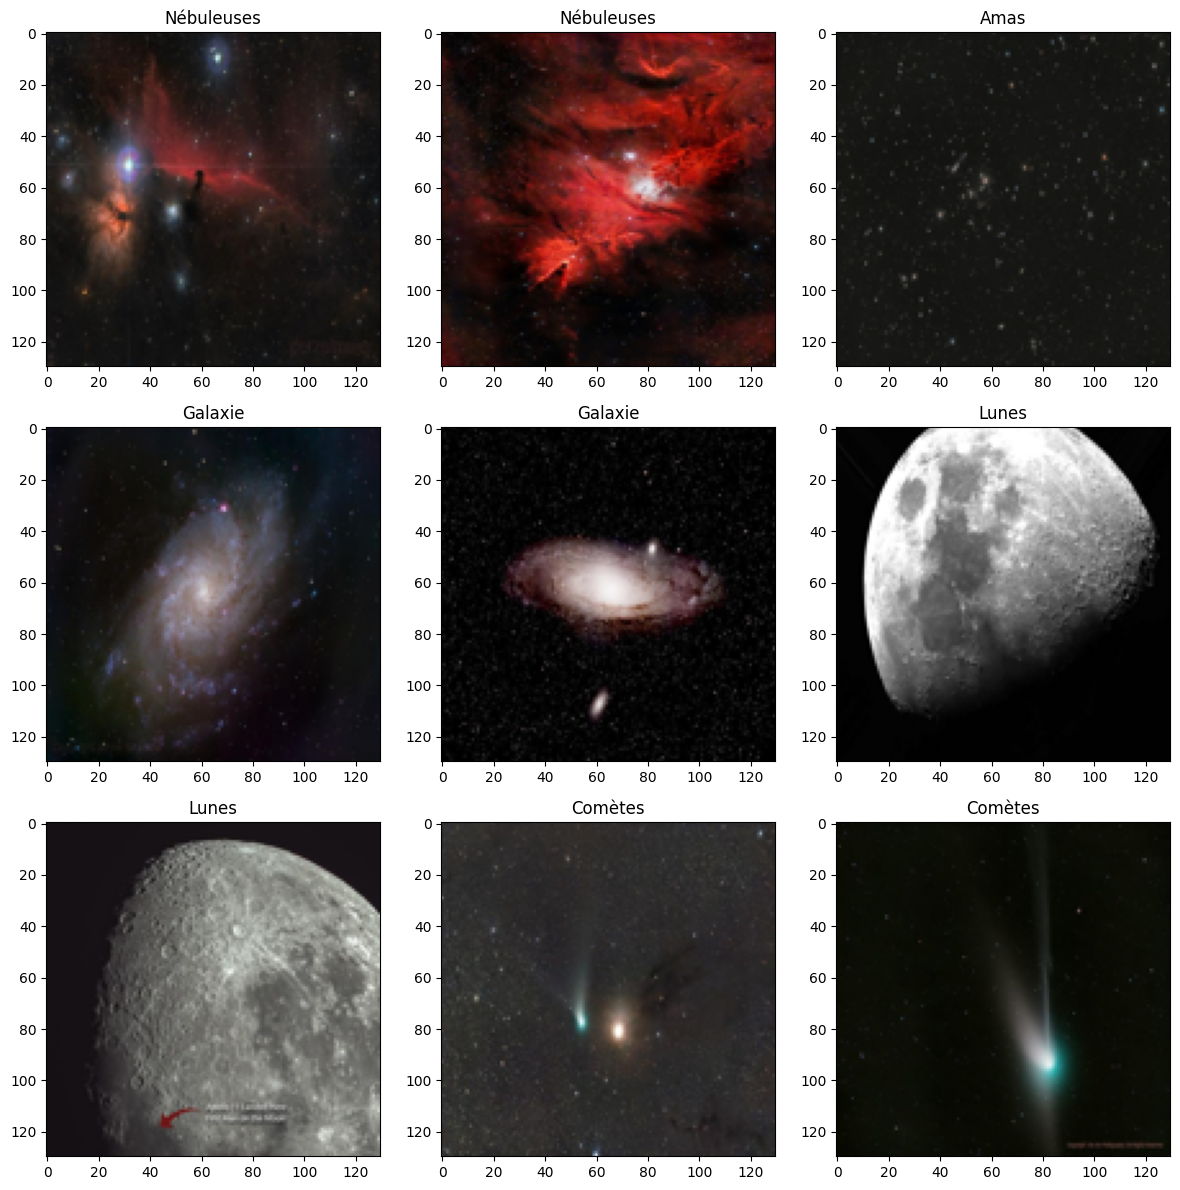

In [21]:
import matplotlib.pyplot as plt
import numpy as np

num_images = 9  # Choix aléatoire entre 1 et 9 images

plt.figure(figsize=(12, 12))

# Générer des indices aléatoires basés sur la taille de x_train
shuffle_indices = np.random.permutation(len(x_train))

for i in range(num_images):
    plt.subplot(3, 3, i+1)  # S'assurer de ne pas dépasser 9
    # Utiliser un index aléatoire pour sélectionner l'image
    image_index = shuffle_indices[i]
    image = x_train[image_index]
    # Afficher le titre basé sur l'étiquette de l'image choisie
    plt.title(labels[int(y_train[image_index])])
    # Normaliser l'image pour l'affichage
    plt.imshow(image / 255)

plt.tight_layout()
plt.show()

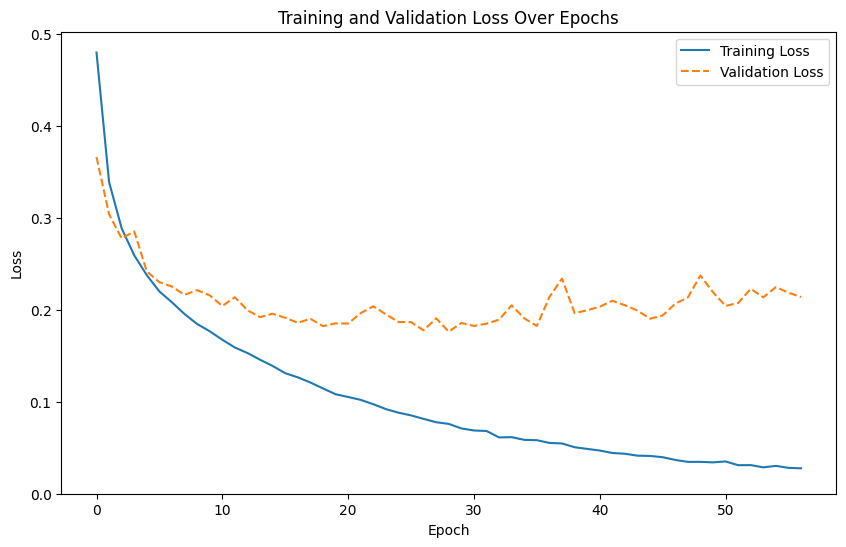

Epoch 57/57: Training Loss 0.0276, Validation Loss 0.2140


In [22]:
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Fonction pour aplatir les images
def flatten_images(images):
    return images.reshape(images.shape[0], -1) / 255.0


def encode_labels(labels, num_classes=3):
    encoder = OneHotEncoder()
    labels = labels.reshape(-1, 1)  # S'assurer que labels est en forme de colonne pour fit_transform
    labels_one_hot = encoder.fit_transform(labels).toarray()
    return labels_one_hot





# Aplatir les images
x_v =  flatten_images(x_val)
y_v = encode_labels(y_val)

x = flatten_images(x_train)
y = encode_labels(y_train)
print(x.shape, y.shape)

# Adapter les dimensions des données d'entrainement et de test pour qu'elles correspondent à l'attente du modèle
input_size = 130*130*3  # 50700 pour des images 130x130x3

# Initialiser le modèle
model = MultiLayerPerceptron()
model.add_layer(DenseLayer(input_size, 125, 'relu'))
model.add_layer(DenseLayer(125, 10, 'relu'))
model.add_layer(DenseLayer(10, 5, 'sigmoid')) 

# Entraîner le modèle
model = SGD(x, y, x_v,y_v, model, 'bce', learning_rate=0.01, epochs=15, batch_size=10)




In [24]:
# Prétraiter x_val et y_val comme x_train et y_train
x_test_flat = flatten_images(x_test)
y_val_encoded = encode_labels(y_test)

# Effectuer une prédiction avec le modèle sur x_val
predictions_val = model.forward(x_test_flat.T)

# Convertir les prédictions en étiquettes réelles
# Ici, vous pouvez utiliser np.argmax pour convertir les prédictions en one-hot encoding vers des étiquettes
predictions_val_labels = np.argmax(predictions_val, axis=0)

# Calculer la précision sur le jeu de validation
accuracy_val = np.mean(predictions_val_labels == y_test.flatten()) * 100
print(f'Précision sur le jeu de test : {accuracy_val:.2f}%')


Précision sur le jeu de test : 81.84%


C:\Users\ludos\AppData\Local\Temp\ipykernel_24964\2381104315.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_label = labels[int(y_test[image_index])]


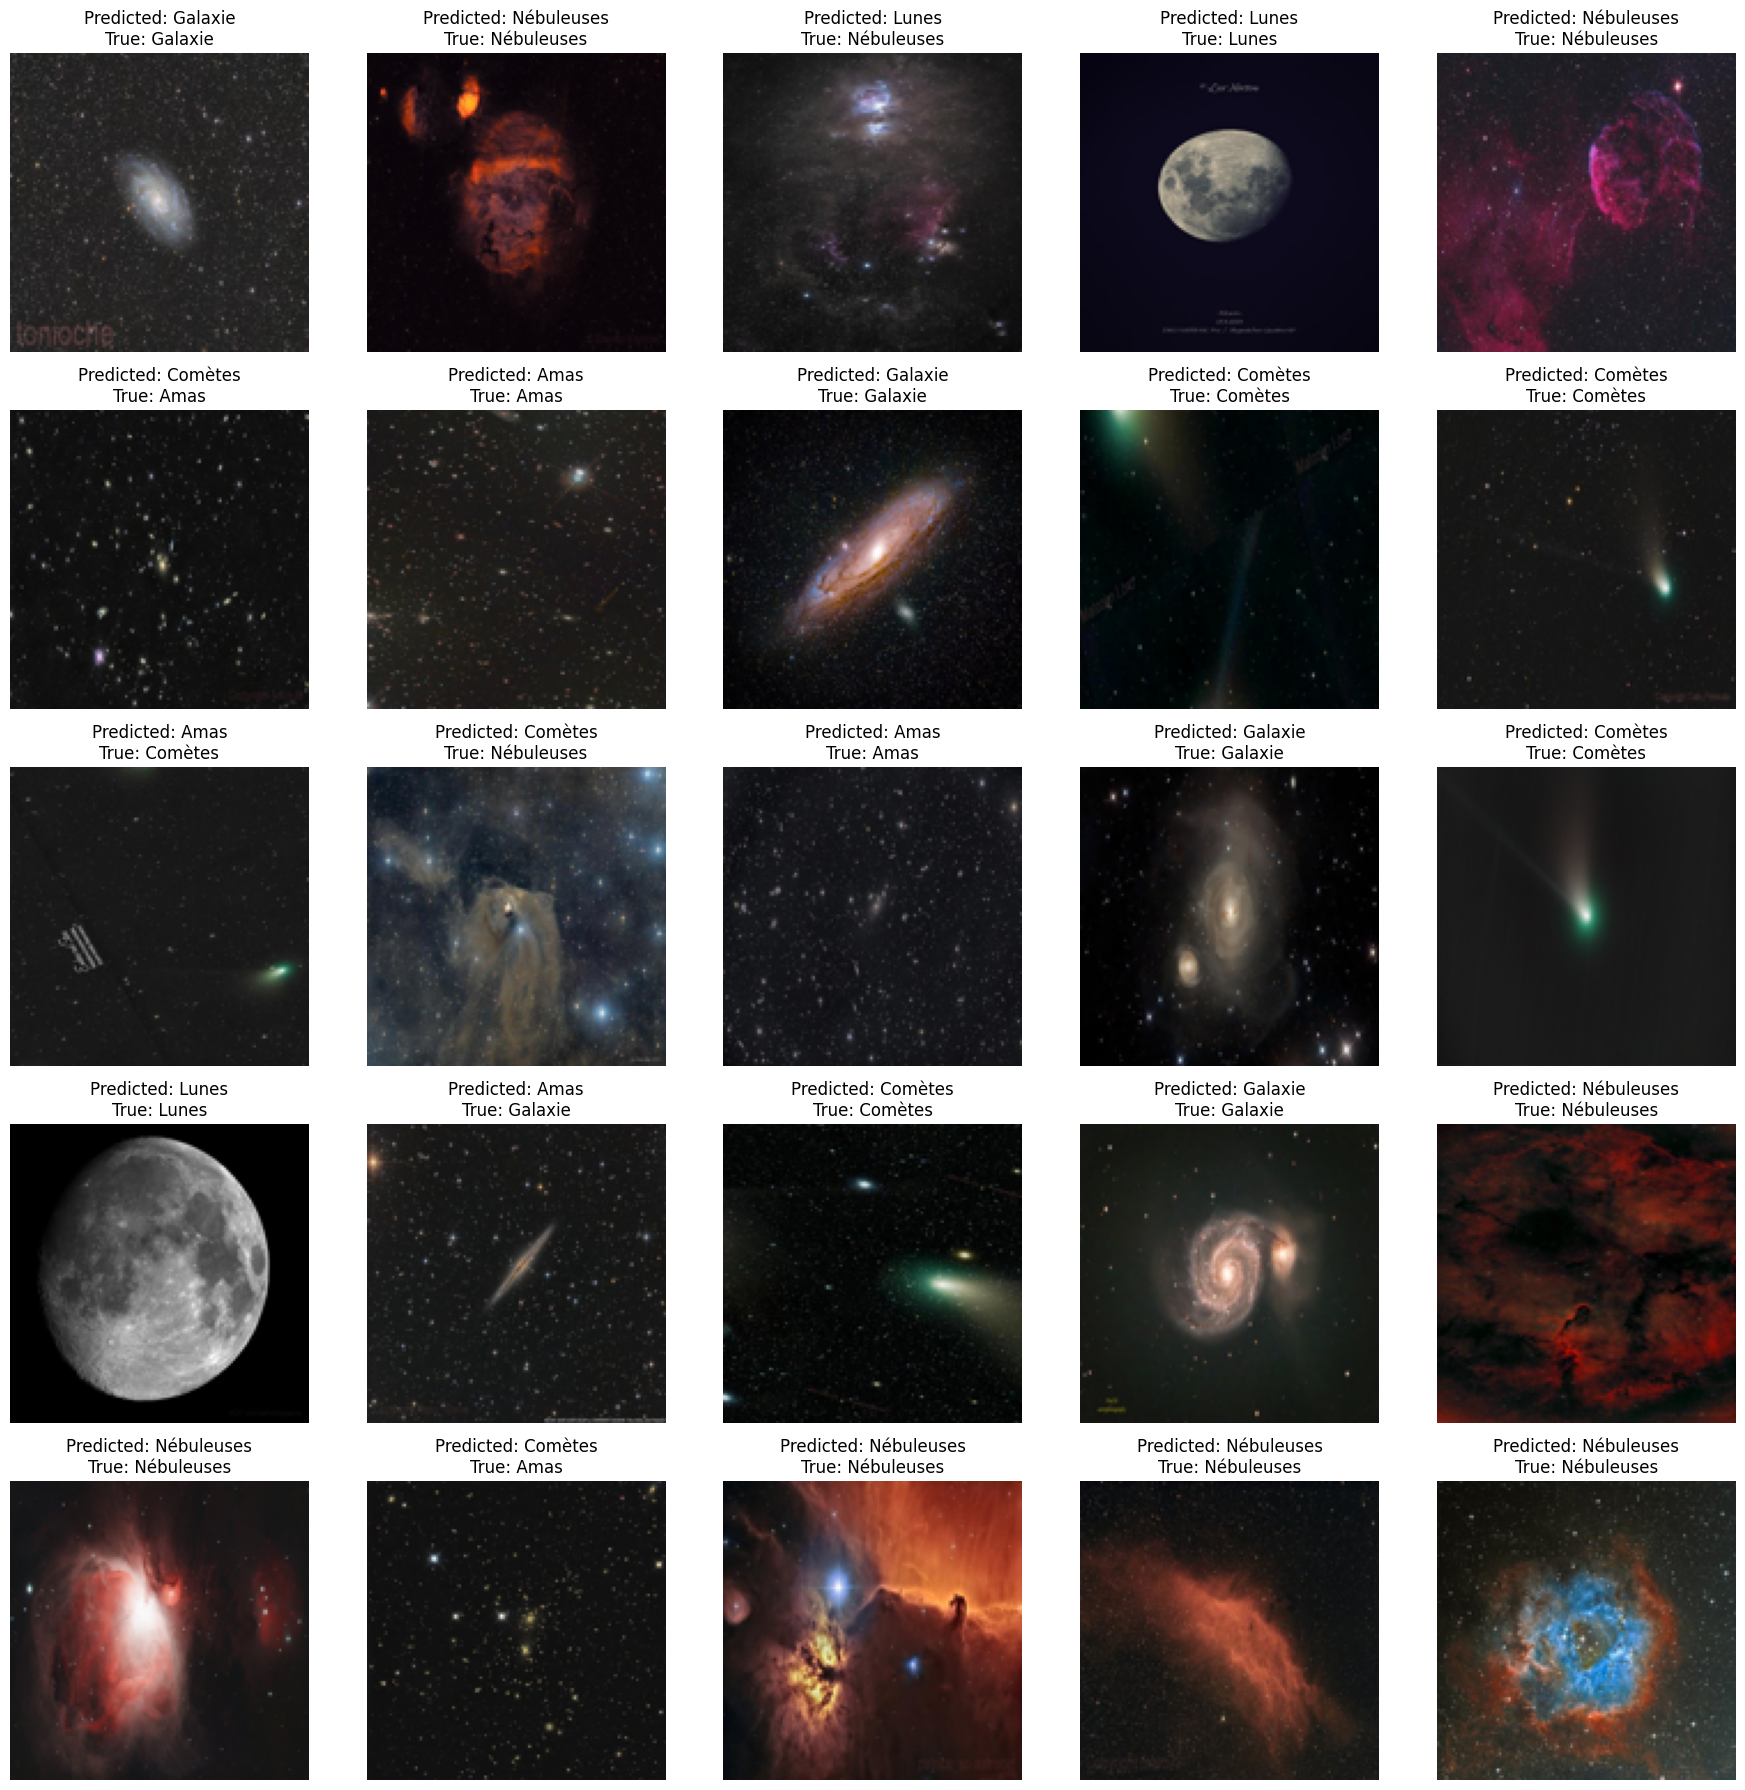

In [26]:
# Prétraiter x_test
x_test_flat = flatten_images(x_test)  # Aplatir les images de test

# Prédire avec le modèle
predictions_test = model.forward(x_test_flat.T)

# Convertir les prédictions de one-hot encoding à des étiquettes
predictions_test_labels = np.argmax(predictions_test, axis=0)


import matplotlib.pyplot as plt
import numpy as np

# Supposons que predictions_test_labels contient les indices des classes prédites pour chaque image de test
num_images = 25  # Nombre d'images à afficher

plt.figure(figsize=(18, 18))

# Générer des indices aléatoires basés sur la taille de x_test
shuffle_indices = np.random.permutation(len(x_test))

for i in range(num_images):
    plt.subplot(5, 5, i+1)  # S'assurer de ne pas dépasser 9
    # Utiliser un index aléatoire pour sélectionner l'image du jeu de test
    image_index = shuffle_indices[i]
    image = x_test[image_index]
    # Obtenir l'étiquette prédite pour l'image sélectionnée
    predicted_label = labels[predictions_test_labels[image_index]]
    # Obtenir l'étiquette réelle pour la comparaison
    true_label = labels[int(y_test[image_index])]
    # Afficher l'image avec l'étiquette prédite et la vraie étiquette
    plt.imshow(image / 255)  # Assurer que les images sont normalisées si nécessaire
    plt.title(f'Predicted: {predicted_label}\nTrue: {true_label}')
    plt.axis('off')  # Masquer les axes pour une meilleure visualisation

plt.tight_layout()
plt.show()

